- <b>목표 : 자전거 렌탈 수요를 예측해 보자</b>
<br><br>
- train : 2년 동안의 매달 1-19일까지의 렌탈 기록
- test : 2년 동안의 매달 20-31일까지의 렌탈 기록
<br><br>
- <b>Data Fields</b>
- datetime : hourly date + timestamp  
- season : 1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday : whether the day is considered a holiday
- workingday : whether the day is neither a weekend nor holiday
- weather : 
    <br>1: Clear, Few clouds, Partly cloudy, Partly cloudy
    <br>2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    <br>3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    <br>4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp : temperature in Celsius
- atemp : "feels like" temperature in Celsius
- humidity : relative humidity
- windspeed : wind speed
- casual : number of non-registered user rentals initiated
- registered : number of registered user rentals initiated
- count : number of total rentals (==> 정답 컬럼, casual + registered)

In [1]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import xgboost
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import make_scorer, mean_squared_log_error

In [2]:
train = pd.read_csv("data/train.csv", parse_dates=["datetime"])
test = pd.read_csv("data/test.csv", parse_dates=["datetime"])
submit = pd.read_csv('data/sampleSubmission.csv', parse_dates=["datetime"])

# 1. EDA

## 1) Variable Identification

- <b>type of variable</b> <br>
predictor : datetime season holiday workingday weather temp atemp humidity windspeed <br>
target : count(= casual + registered)
<br><br>
- <b>data type</b> <br>
charater : datetime<br>
numeric : the others
<br><br>
- <b>variable category</b> <br>
categorical : datetime season holiday workingday weather <br>
continuous : temp atemp humidity windspeed casual registered count

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


## 2) Univariate Analysis

### (1) categorical
- holiday, workingday, weather의 분포 차이가 컸음
- 나머지는 고르게 분포

#### datetime(year, month, day, hour, dayofweek)

In [5]:
"""datetime 변수에서 새로운 변수 year, month, day, hour, dayOfWeek 만들기"""

train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['dayOfWeek'] = train['datetime'].dt.dayofweek
train.drop('datetime', axis=1, inplace=True)

test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['dayOfWeek'] = test['datetime'].dt.dayofweek
test.drop('datetime', axis=1, inplace=True)

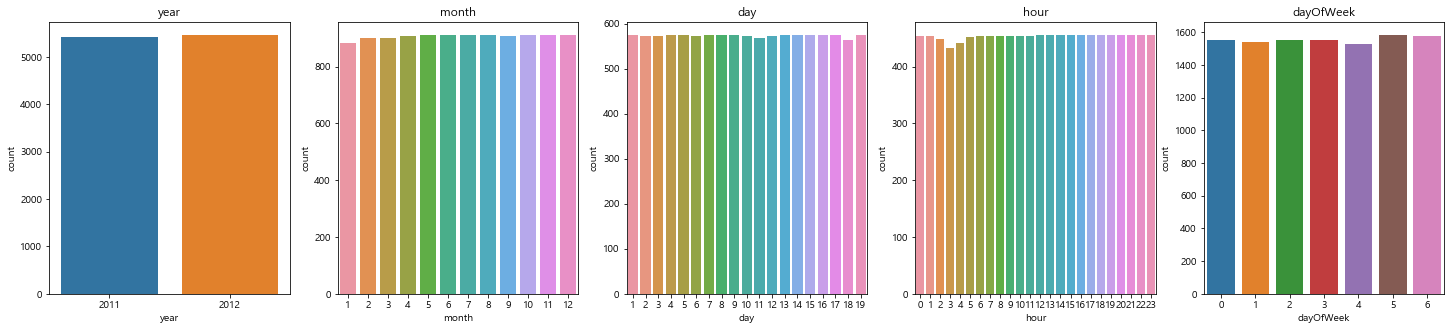

In [9]:
figure, axes = plt.subplots(nrows=1, ncols=5)
figure.set_size_inches(25,5)
sns.countplot(x='year', data=train, ax=axes[0])
sns.countplot(x='month', data=train, ax=axes[1])
sns.countplot(x='day', data=train, ax=axes[2])
sns.countplot(x='hour', data=train, ax=axes[3])
sns.countplot(x='dayOfWeek', data=train, ax=axes[4])
axes[0].set_title('year')
axes[1].set_title('month')
axes[2].set_title('day')
axes[3].set_title('hour')
axes[4].set_title('dayOfWeek')
plt.show()

#### season, holiday, workingday, weather

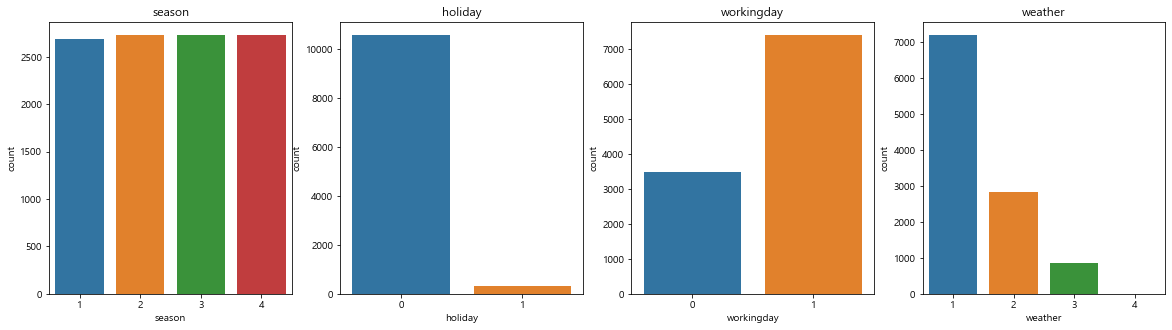

In [10]:
figure, axes = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(20,5)
sns.countplot(x='season', data=train, ax=axes[0])
sns.countplot(x='holiday', data=train, ax=axes[1])
sns.countplot(x='workingday', data=train, ax=axes[2])
sns.countplot(x='weather', data=train, ax=axes[3])
axes[0].set_title('season')
axes[1].set_title('holiday')
axes[2].set_title('workingday')
axes[3].set_title('weather')
plt.show()

### (2) continuous

#### temp atemp humidity windspeed
- humidity, windspeed -> outlier 확인 필요!

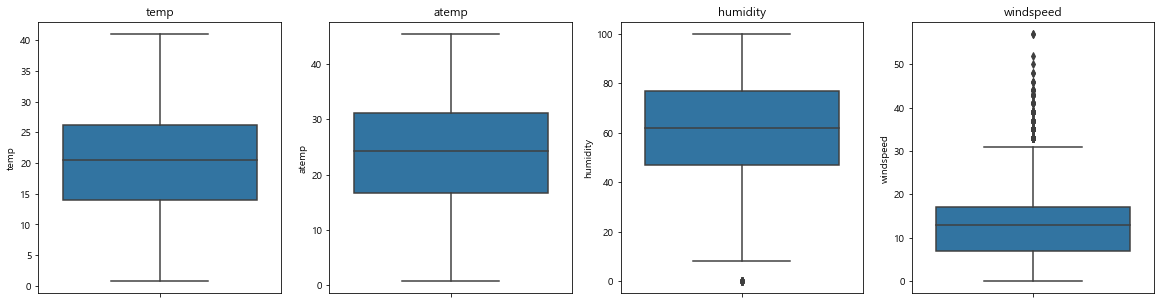

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=4)
figure.set_size_inches(20,5)
sns.boxplot(y='temp', data=train, ax=axes[0])
sns.boxplot(y='atemp', data=train, ax=axes[1])
sns.boxplot(y='humidity', data=train, ax=axes[2])
sns.boxplot(y='windspeed', data=train, ax=axes[3])
axes[0].set_title('temp')
axes[1].set_title('atemp')
axes[2].set_title('humidity')
axes[3].set_title('windspeed')
plt.show()

#### casual registered count
- 굉장히 치우쳐 있음!

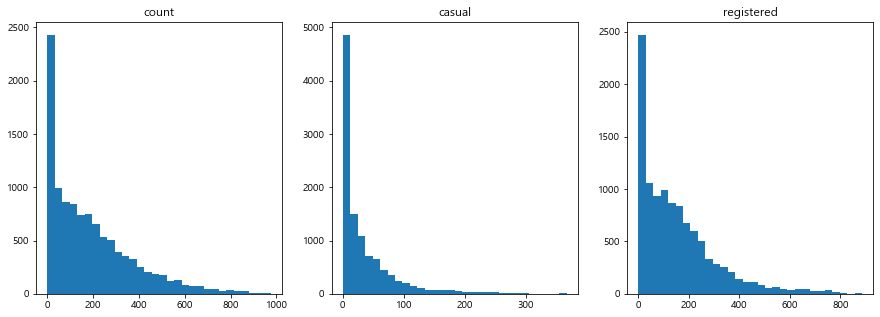

In [12]:
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)
axes[0].hist(train['count'], bins=30)
axes[1].hist(train['casual'], bins=30)
axes[2].hist(train['registered'], bins=30)
axes[0].set_title('count')
axes[1].set_title('casual')
axes[2].set_title('registered')
plt.show()

## 3) Bi-variate Analysis
- 변수를 크게 time과 weather로 나누었을 때, <br>
time 변수들 에서는 casual과 registered의 차이가 있었으나 <br>
weather 변수들에서는 큰 차이가 없었음 <br>
(time 변수들 : datetime, season, holiday, workingday <br>
weather 변수들 : weather, temp, atemp, humidity, windspeed) <br><br>

- ★★★모델링 방향★★★
- 하나. count를 예측하는 회귀 모델
- 둘. casual 예측값 + registererd 예측값을 사용하면 에러를 더 줄일 수 있지 않을까

### (1) target & Categorical

#### datetime과 target
- day 변수는 train과 test가 다르기 때문에 분석 시 제외
<br><br>
- casual(미등록 렌탈)과 registered(등록 렌탈)의 차이가 있었음
- casual : 4월 ~ 9월 / 10시 ~ 19시 / 주말에 상대적으로 더 많이 빌림 -> 따뜻한 시기 주말에 놀러갈 때 빌리는 것으로 추측(레저용)
- registered : 5월 ~ 12월 / 7 ~ 10시, 17 ~ 19시 / 평일에 상대적으로 더 많이 빌림 -> 평상 시 출퇴근 용으로 빌리는 것으로 파악(출퇴근용)

In [6]:
train['month_str'] = np.where(train['month']<10, '0'+train['month'].astype(str), train['month'].astype(str))
train['year_month'] = train['year'].astype(str)+train['month_str']

test['month_str'] = np.where(test['month']<10, '0'+test['month'].astype(str), test['month'].astype(str))
test['year_month'] = test['year'].astype(str)+test['month_str']

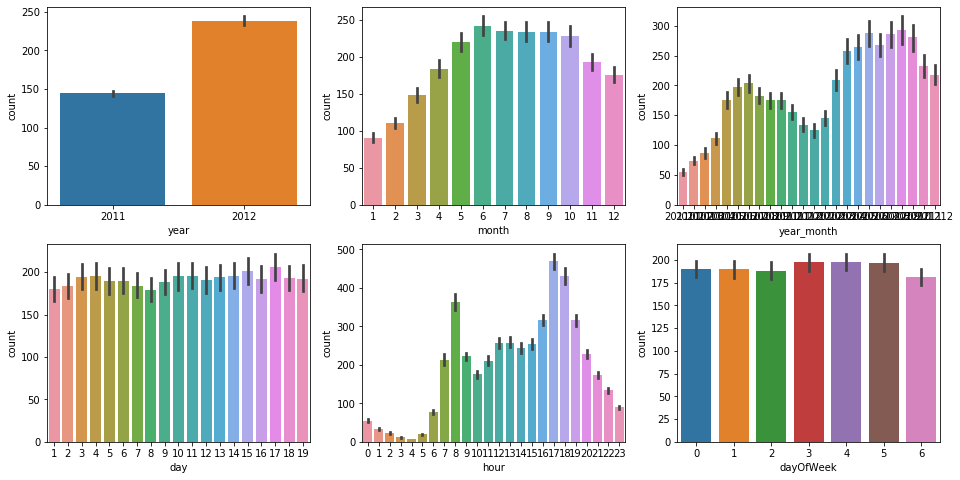

In [19]:
"""===== count ====="""
figure, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(16,8)
sns.barplot(data = train, x='year', y='count', ax=ax1)
sns.barplot(data = train, x='month', y='count', ax=ax2)
sns.barplot(data = train, x='year_month', y='count', ax=ax3)
sns.barplot(data = train, x='day', y='count', ax=ax4)
sns.barplot(data = train, x='hour', y='count', ax=ax5)
sns.barplot(data = train, x='dayOfWeek', y='count', ax=ax6)
plt.show()

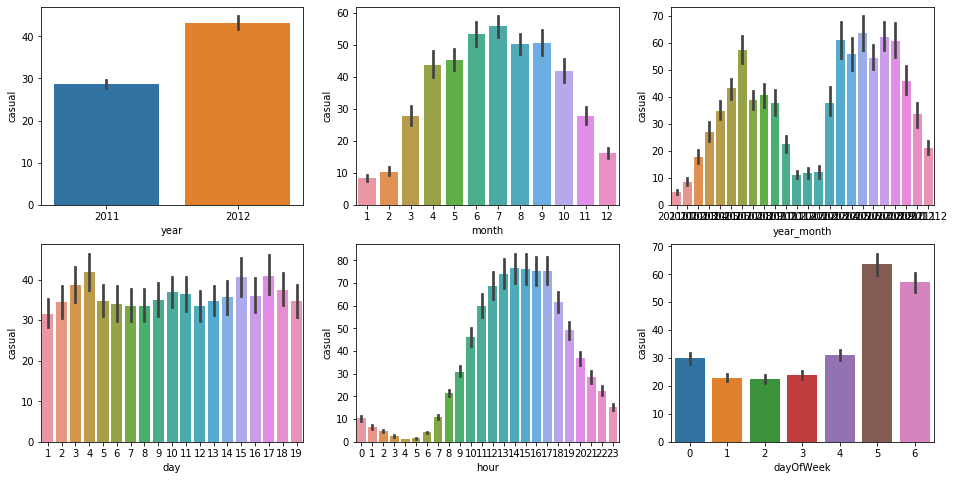

In [20]:
"""===== casual ====="""
figure, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(16,8)
sns.barplot(data = train, x='year', y='casual', ax=ax1)
sns.barplot(data = train, x='month', y='casual', ax=ax2)
sns.barplot(data = train, x='year_month', y='casual', ax=ax3)
sns.barplot(data = train, x='day', y='casual', ax=ax4)
sns.barplot(data = train, x='hour', y='casual', ax=ax5)
sns.barplot(data = train, x='dayOfWeek', y='casual', ax=ax6)
plt.show()

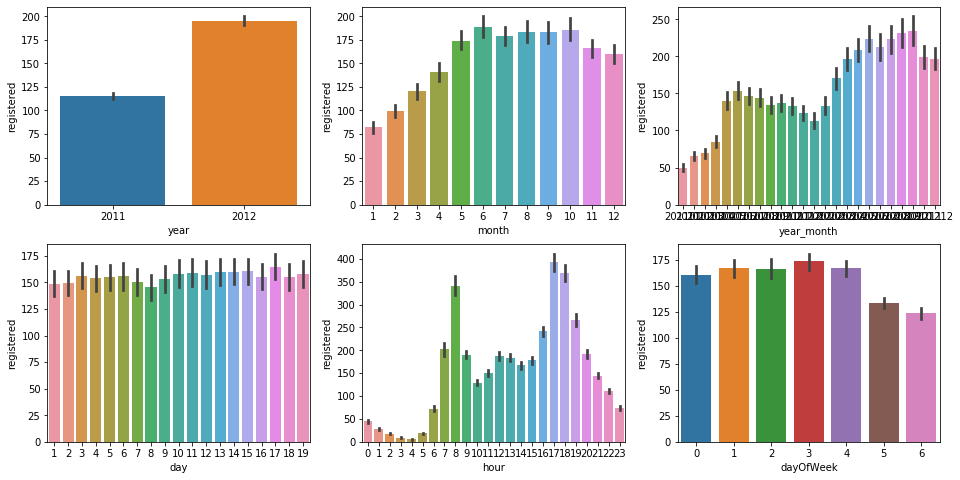

In [21]:
"""===== registered ====="""
figure, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(16,8)
sns.barplot(data = train, x='year', y='registered', ax=ax1)
sns.barplot(data = train, x='month', y='registered', ax=ax2)
sns.barplot(data = train, x='year_month', y='registered', ax=ax3)
sns.barplot(data = train, x='day', y='registered', ax=ax4)
sns.barplot(data = train, x='hour', y='registered', ax=ax5)
sns.barplot(data = train, x='dayOfWeek', y='registered', ax=ax6)
plt.show()

#### season
- spring, winter에서 registered가 casual보다 상대적으로 더 많이 빌림

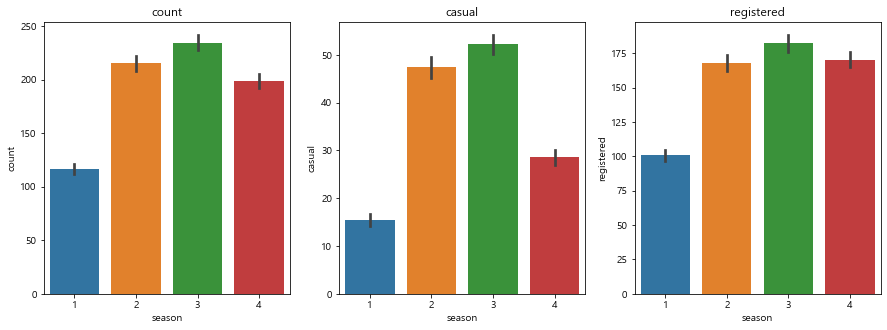

In [19]:
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)
sns.barplot(data = train, x='season', y='count', ax=axes[0])
sns.barplot(data = train, x='season', y='casual', ax=axes[1])
sns.barplot(data = train, x='season', y='registered', ax=axes[2])
axes[0].set_title('count')
axes[1].set_title('casual')
axes[2].set_title('registered')
plt.show()

#### holiday, workingday
- holiday에는 casual이, workingday에는 registered가 렌탈이 더 많았음

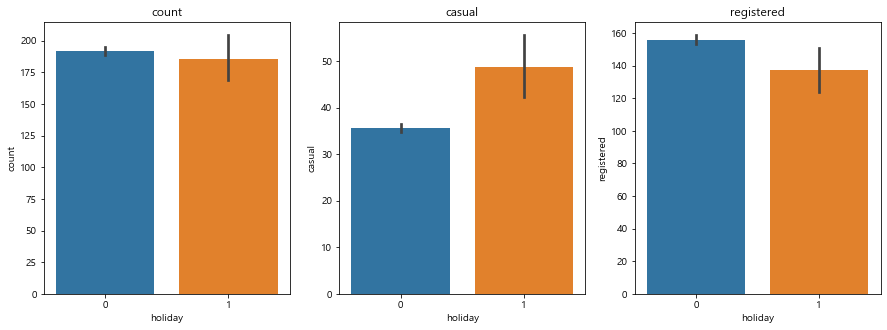

In [23]:
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)
sns.barplot(data = train, x='holiday', y='count', ax=axes[0])
sns.barplot(data = train, x='holiday', y='casual', ax=axes[1])
sns.barplot(data = train, x='holiday', y='registered', ax=axes[2])
axes[0].set_title('count')
axes[1].set_title('casual')
axes[2].set_title('registered')
plt.show()

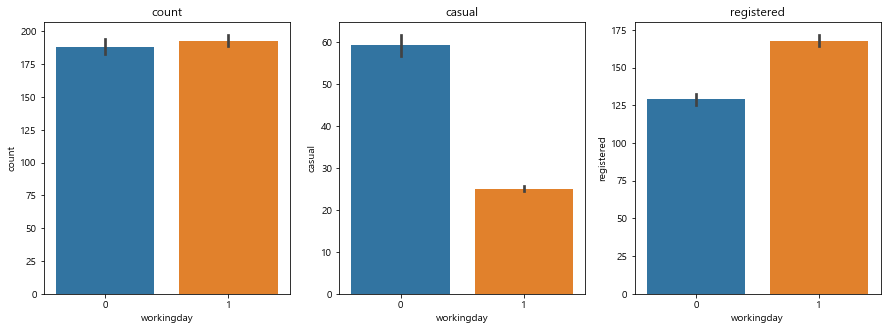

In [24]:
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)
sns.barplot(data = train, x='workingday', y='count', ax=axes[0])
sns.barplot(data = train, x='workingday', y='casual', ax=axes[1])
sns.barplot(data = train, x='workingday', y='registered', ax=axes[2])
axes[0].set_title('count')
axes[1].set_title('casual')
axes[2].set_title('registered')
plt.show()

#### weather
- 날씨가 궂을수록 렌탈 횟수가 줄어듦

In [26]:
tempData = train[train['weather']<4]

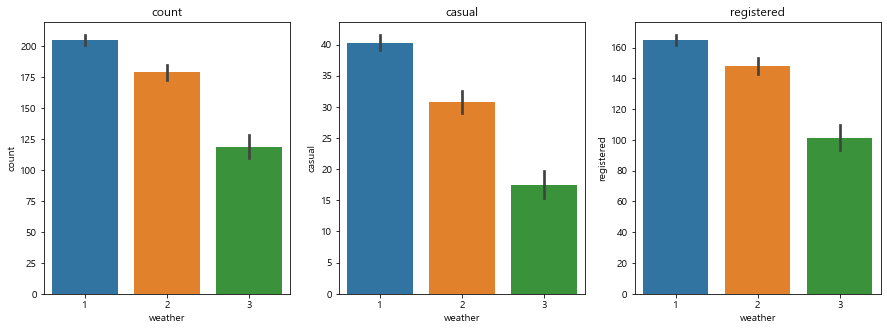

In [27]:
figure, axes = plt.subplots(nrows=1, ncols=3)
figure.set_size_inches(15,5)
sns.barplot(data = tempData, x='weather', y='count', ax=axes[0])
sns.barplot(data = tempData, x='weather', y='casual', ax=axes[1])
sns.barplot(data = tempData, x='weather', y='registered', ax=axes[2])
axes[0].set_title('count')
axes[1].set_title('casual')
axes[2].set_title('registered')
plt.show()

### (2) target & Continuous

#### scatter plot & correlation
- temp와 atemp, registered와 count간에 강한 양의 상관관계가 있음
- temp/atemp와 target variables(특히 casual) 사이에 양의 상관관계가 있어 보임
- humidity와 target, windspeed는 음의 상관관계가 있어 보임

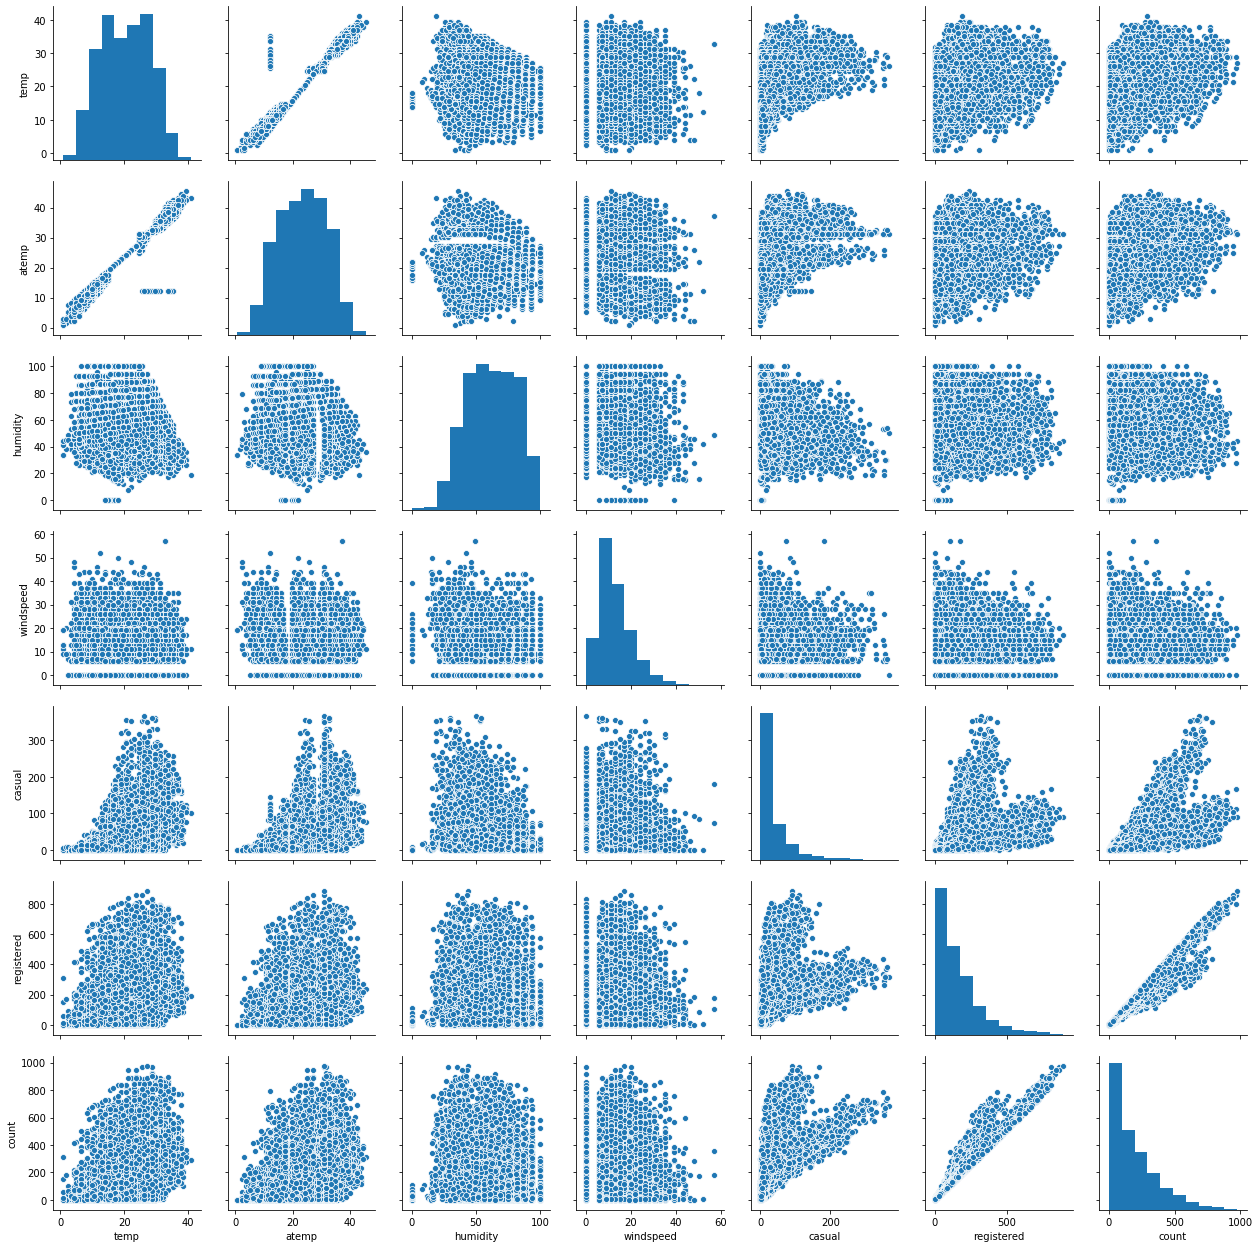

In [16]:
sns.pairplot(train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']])

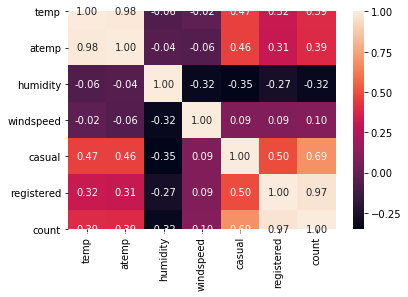

In [17]:
corr = train[['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']].corr()
sns.heatmap(corr, annot=True, fmt='.2f')

#### temp, atemp, humidity, windspeed
- 온도 : 전체적으로 온도가 높을수록 렌탈 횟수 증가, 온도 약 28도/체감온도 약 30도 이상일때 크게 증가
- 습도 : 약 15도에서 급격히 상승, 이후 점진적으로 감소
- 바람세기 : 약 35 이상일 때 감소 추세

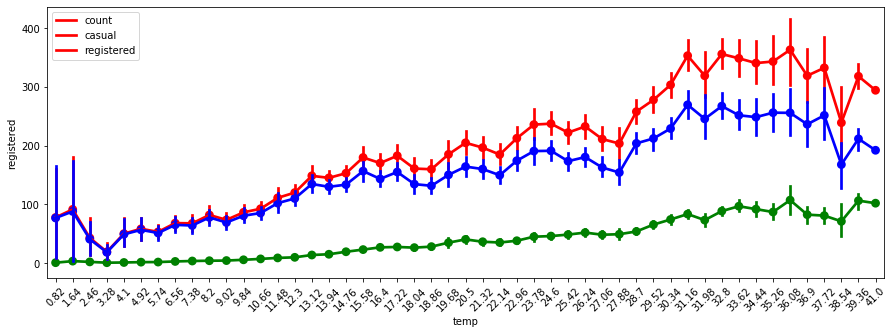

In [27]:
plt.figure(figsize=(15,5))
sns.pointplot(data=train, x='temp', y='count', color='red')
sns.pointplot(data=train, x='temp', y='casual', color='green')
sns.pointplot(data=train, x='temp', y='registered', color='blue')
plt.legend(labels=['count','casual','registered'])
plt.xticks(rotation=45)
plt.show()

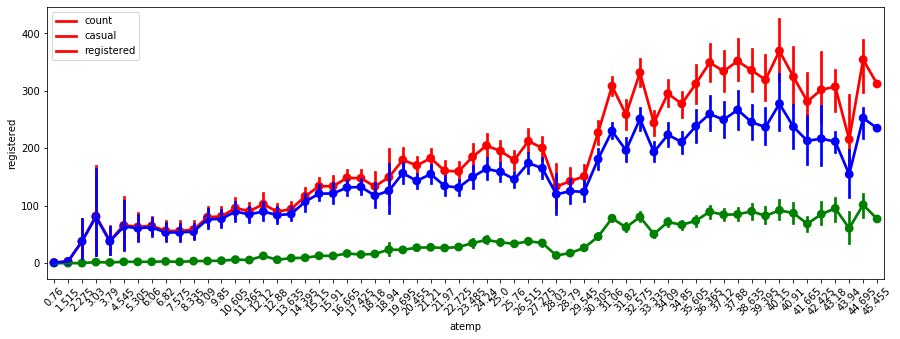

In [28]:
plt.figure(figsize=(15,5))
sns.pointplot(data=train, x='atemp', y='count', color='red')
sns.pointplot(data=train, x='atemp', y='casual', color='green')
sns.pointplot(data=train, x='atemp', y='registered', color='blue')
plt.legend(labels=['count','casual','registered'])
plt.xticks(rotation=45)
plt.show()

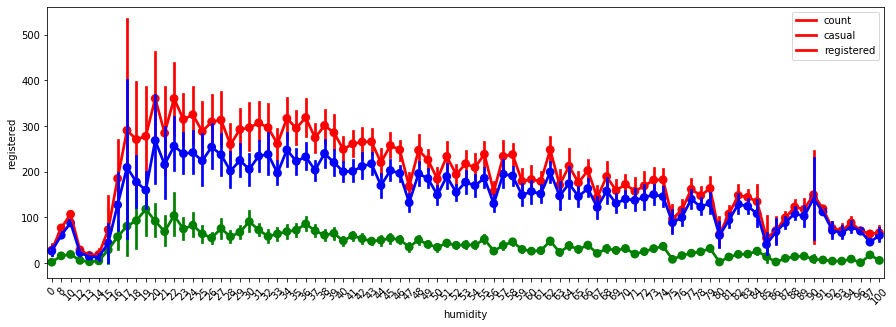

In [29]:
plt.figure(figsize=(15,5))
sns.pointplot(data=train, x='humidity', y='count', color='red')
sns.pointplot(data=train, x='humidity', y='casual', color='green')
sns.pointplot(data=train, x='humidity', y='registered', color='blue')
plt.legend(labels=['count','casual','registered'])
plt.xticks(rotation=45)
plt.show()

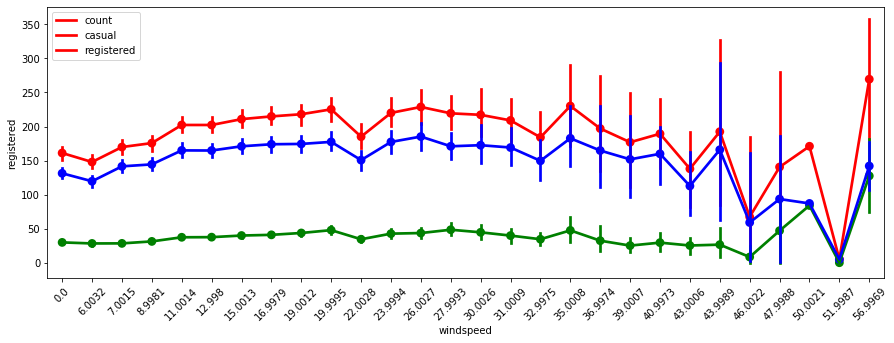

In [30]:
plt.figure(figsize=(15,5))
sns.pointplot(data=train, x='windspeed', y='count', color='red')
sns.pointplot(data=train, x='windspeed', y='casual', color='green')
sns.pointplot(data=train, x='windspeed', y='registered', color='blue')
plt.legend(labels=['count','casual','registered'])
plt.xticks(rotation=45)
plt.show()

# 2. Missing Value

### - missing data 없음!

In [31]:
train.isnull().sum().sum()

0

In [32]:
test.isnull().sum().sum()

0

### - windspeed
- 바람속도가 0일 때가 너무 많음 -> 그대로 두기(바람속도가 진짜로 0이거나 0~5이거나 관측이 안되었거나...)

In [33]:
train['windspeed'].value_counts().sort_index()

0.0000     1313
6.0032      872
7.0015     1034
8.9981     1120
11.0014    1057
12.9980    1042
15.0013     961
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
36.9974      22
39.0007      27
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: windspeed, dtype: int64

In [34]:
test['windspeed'].value_counts().sort_index()

0.0000     867
6.0032     553
7.0015     583
8.9981     618
11.0014    638
12.9980    615
15.0013    552
16.9979    471
19.0012    372
19.9995    316
22.0028    230
23.9994    186
26.0027    146
27.9993    109
30.0026     65
31.0009     57
32.9975     32
35.0008     26
36.9974     17
39.0007     17
40.9973     12
43.0006      2
43.9989      3
46.0022      2
50.0021      1
54.0020      2
55.9986      1
Name: windspeed, dtype: int64

# 3. Outlier

### 1) humidity
- 2011년 3월 11일 습도가 모두 0 -> 삭제

In [8]:
Q1 = np.percentile(train['humidity'], 25)
Q3 = np.percentile(train['humidity'], 75)
IQR = Q3 - Q1
range_IQR = 1.5 * IQR

In [9]:
train[(train['humidity'] < Q1 - range_IQR) | (train['humidity'] > Q3 + range_IQR)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayOfWeek,month_str,year_month
1091,1,0,1,3,13.94,15.910,0,16.9979,3,0,3,2011,3,10,0,3,03,201103
1092,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,2011,3,10,1,3,03,201103
1093,1,0,1,3,13.94,15.910,0,16.9979,0,1,1,2011,3,10,2,3,03,201103
1094,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,2011,3,10,5,3,03,201103
1095,1,0,1,3,14.76,16.665,0,22.0028,0,12,12,2011,3,10,6,3,03,201103
1096,1,0,1,3,15.58,19.695,0,15.0013,1,36,37,2011,3,10,7,3,03,201103
1097,1,0,1,3,15.58,19.695,0,19.0012,1,43,44,2011,3,10,8,3,03,201103
1098,1,0,1,3,16.40,20.455,0,15.0013,1,23,24,2011,3,10,9,3,03,201103
1099,1,0,1,3,16.40,20.455,0,11.0014,0,17,17,2011,3,10,10,3,03,201103
1100,1,0,1,3,16.40,20.455,0,16.9979,6,5,11,2011,3,10,11,3,03,201103


In [10]:
outlier = train[(train['humidity'] < Q1 - range_IQR) | (train['humidity'] > Q3 + range_IQR)].index
train.drop(outlier, inplace=True)

#### - 습도가 100일 때 날씨가 좋은 경우가 있음 -> 상대습도라서 그럴 수 있다고 함...?

In [11]:
train[train['humidity']==100]['weather'].value_counts()

3    81
2    58
1     9
Name: weather, dtype: int64

### 2) temp, atemp
- 2012년 8월 17일 체감온도가 모두 12.12 -> 삭제

In [12]:
train[(train['temp']>20) & (train['atemp']<20)]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayOfWeek,month_str,year_month
8991,3,0,1,1,27.88,12.12,57,11.0014,21,67,88,2012,8,17,0,4,08,201208
8992,3,0,1,1,27.06,12.12,65,7.0015,16,38,54,2012,8,17,1,4,08,201208
8993,3,0,1,1,27.06,12.12,61,8.9981,4,15,19,2012,8,17,2,4,08,201208
8994,3,0,1,1,26.24,12.12,65,7.0015,0,6,6,2012,8,17,3,4,08,201208
8995,3,0,1,1,26.24,12.12,73,11.0014,0,9,9,2012,8,17,4,4,08,201208
8996,3,0,1,1,26.24,12.12,73,7.0015,2,34,36,2012,8,17,5,4,08,201208
8997,3,0,1,1,25.42,12.12,78,8.9981,6,151,157,2012,8,17,6,4,08,201208
8998,3,0,1,1,26.24,12.12,73,7.0015,11,368,379,2012,8,17,7,4,08,201208
8999,3,0,1,1,27.88,12.12,65,8.9981,43,625,668,2012,8,17,8,4,08,201208
9000,3,0,1,1,28.70,12.12,58,7.0015,58,320,378,2012,8,17,9,4,08,201208


In [13]:
outlier = train[(train['temp']>20) & (train['atemp']<20)].index
train.drop(outlier, inplace=True)

# 4. Feature Engineering

### 1) target 변수 -> 로그 적용하기!

In [14]:
train['casual'] = np.log(train['casual']+1)
train['registered'] = np.log(train['registered']+1)
train['count'] = np.log(train['count']+1)

### 2) 새로운 변수 만들기

#### year_month -> 3개월씩 나누기

In [15]:
# 부여할 값 (1~8)
value = []
for i in range(1,9): value.extend([i]*3) 

# mapping할 키
mapping = pd.Series(value, index=np.unique(train['year_month']))

# 적용
train['year_month'] = train['year_month'].map(mapping)
test['year_month'] = test['year_month'].map(mapping)

#### hour 나누기

In [16]:
train['hourForRegi'] = np.where(train['hour']<=6, 1, np.where(train['hour']<=9, 2, np.where(train['hour']<=16,3,np.where(train['hour']<=19,4,5))))
test['hourForRegi'] = np.where(test['hour']<=6, 1, np.where(test['hour']<=9, 2, np.where(test['hour']<=16,3,np.where(test['hour']<=19,4,5))))

In [17]:
train['hourForCas'] = np.where(train['hour']<=6, 1, np.where(train['hour']<=12, 2, np.where(train['hour']<=18,3,4)))
train['hourForCas'] = np.where(train['hour']==0, 4, train['hourForCas'])

test['hourForCas'] = np.where(test['hour']<=6, 1, np.where(test['hour']<=12, 2, np.where(test['hour']<=18,3,4)))
test['hourForCas'] = np.where(test['hour']==0, 4, test['hourForCas'])

#### holiday, workingday, day -> weekday, weekend, holiday

In [18]:
mapping = {
    -1: 0, # weekday(workingday)
     0: 1, # weekend
     1: 2  # hoilday(weekend 포함되어 있음)
}

train['typeOfDay'] = (train['holiday'] - train['workingday']).map(mapping)
train['weekend'] = np.where(train['day']>=5, 1, 0)

test['typeOfDay'] = (test['holiday'] - test['workingday']).map(mapping)
test['weekend'] = np.where(test['day']>=5, 1, 0)

#### temp 나누기

In [19]:
# bins = [0,15,28,37,50]
# labels=[1,2,3,4]
train['tempCate'] = pd.cut(train['temp'], bins = 3, labels=[1,2,3])
test['tempCate'] = pd.cut(test['temp'], bins = 3, labels=[1,2,3])

#### atemp 나누기

In [20]:
# bins = [0,15,28,37,50]
# labels=[1,2,3,4]
train['atempCate'] = pd.cut(train['atemp'], bins = 3, labels=[1,2,3])
test['atempCate'] = pd.cut(test['atemp'], bins = 3, labels=[1,2,3])

#### humidity 나누기

In [21]:
# bins = [0,15,30,45,60,75,90,100]
# labels=[1,2,3,4,5,6,7]
train['humidityCate'] = pd.cut(train['humidity'], bins = 3, labels=[1,2,3])
test['humidityCate'] = pd.cut(test['humidity'], bins = 3, labels=[1,2,3])

#### 데이터 타입 바꾸기

In [22]:
cols = ['tempCate','atempCate','humidityCate']
for col in cols:
    train[col] = train[col].astype('int')
    test[col] = test[col].astype('int')

### 3) feature selection
- 새로 만든 변수들은 별로 효과가 없었음....ㅜㅜ

In [23]:
feature_names = ['year','season','hour','dayOfWeek','holiday','workingday','weather', 'tempCate', 'atemp', 'humidity','windspeed']
train_sel = train[feature_names]
test_sel = test[feature_names]

# 5. Modeling

In [102]:
X = train_sel
y = train['count']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_sel.shape

((8672, 11), (8672,), (2168, 11), (2168,), (6493, 11))

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [39]:
def rmsle(predicted_values, actual_values, convertExp=True):
    """
    rmsle : root mean squared log error
            예측값과 정답값에 로그를 적용한 후 그 차이값을 제곱하고 평균을 낸 뒤 루트 씌우기!
            (이 함수에서는 원래 값을 유지하기 위해 로그 전에 np.exp 적용함!)
    """ 
    
    if convertExp:
        predicted_values = np.exp(predicted_values),
        actual_values = np.exp(actual_values)
       
    log_predicted_values = np.log(np.array(predicted_values)+1)
    log_actual_values = np.log(np.array(actual_values)+1)

    difference = np.square(log_predicted_values - log_actual_values)
    
    return np.sqrt(difference.mean())

In [40]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

### 1) Linear Regession

In [55]:
# 생성 및 초기화
modelLinear = LinearRegression() 

# 학습
modelLinear.fit(X_train, y_train) 

# 평가
pred = modelLinear.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelLinear.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(np.exp(y_test),np.exp(pred), False))

X_train(RMSLE) :  0.9790906151478574
평가 결과(RMSLE) :  0.9632884927375583


### 2) Ridge

best params : {'alpha': 100, 'max_iter': 3000}
best score : 0.9807833606494674
평가 결과(RMSLE) :  0.9631462626842326


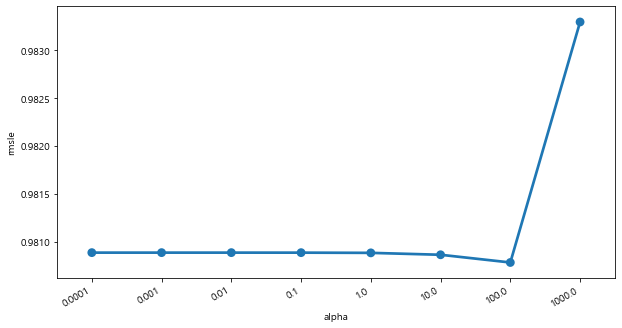

In [56]:
# 생성 및 초기화
modelRidge = Ridge()

# 그리드서치
params = {
    'max_iter':[3000],
    'alpha':[0.0001, 0.001, 0.01, 0.1, 1,10, 100, 1000]
}
gridRidge = GridSearchCV(modelRidge, params, scoring=rmsle_scorer, cv=5) # 그리드서치 생성 및 초기화
gridRidge.fit(X_train, y_train) # 학습
pred = gridRidge.predict(X_test) # 예측
print("best params : {}".format(gridRidge.best_params_)) # 결과 출력
print("best score : {}". format(-gridRidge.best_score_))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

plt.figure(figsize=(10,5))
df = pd.DataFrame(gridRidge.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle")
plt.show()

### 3) Lasso

best params : {'alpha': 0.01, 'max_iter': 10000}
best score : 0.9804067762730234
평가 결과(RMSLE) :  0.9632558187953454


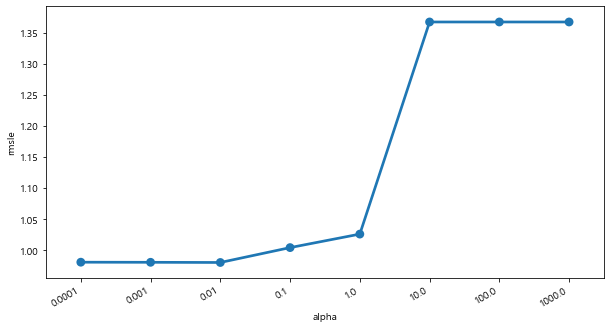

In [57]:
modelLasso = Lasso()

params = {
    'max_iter':[10000],
    'alpha':[0.0001, 0.001, 0.01, 0.1, 1,10, 100, 1000]
}
gridLasso = GridSearchCV(modelLasso, params, scoring=rmsle_scorer, cv=5)
gridLasso.fit(X_train, y_train)
pred = gridLasso.predict(X_test)
print("best params : {}".format(gridLasso.best_params_))
print("best score : {}". format(-gridLasso.best_score_))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

plt.figure(figsize=(10,5))
df = pd.DataFrame(gridLasso.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle")
plt.show()

### 3) RandomForest

In [58]:
modelRF = RandomForestRegressor(n_estimators=1000, max_depth=15)

modelRF.fit(X_train, y_train)

pred = modelRF.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelRF.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.1259450926398539
평가 결과(RMSLE) :  0.28930951146390677


### 4) Gradient Boost

In [59]:
modelGB = GradientBoostingRegressor(n_estimators=1000, max_depth=5)

modelGB.fit(X_train, y_train)

pred = modelGB.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelGB.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.13866865934304257
평가 결과(RMSLE) :  0.2758083053907817


### 5) XGBoost
- kaggle 제출 결과 : 0.38725

In [60]:
modelXGB = XGBRegressor(n_estimators=500,
                        max_depth=6,
                        learning_rate=0.1,
                        seed=3,
                        objective='reg:squarederror')

modelXGB.fit(X_train, y_train)

pred = modelXGB.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.13440056181715074
평가 결과(RMSLE) :  0.2770118253935378


In [61]:
submit['count'] = np.exp(modelXGB.predict(test_sel))-1
submit.to_csv('submit/xgb.csv', index=False)

### 6) casual과 registered로 예측해보자
- kaggle 제출 결과 : 0.38023

#### casual

In [62]:
X = train_sel
y = train['casual']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_sel.shape

((8672, 11), (8672,), (2168, 11), (2168,), (6493, 11))

In [63]:
modelXGB_c = XGBRegressor(n_estimators=500,
                        max_depth=6,
                        learning_rate=0.1,
                        seed=3,
                        objective='reg:squarederror')

modelXGB_c.fit(X_train, y_train)

pred = modelXGB_c.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB_c.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.22323562336635547
평가 결과(RMSLE) :  0.40544030550474136


#### registered

In [64]:
X = train_sel
y = train['registered']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_sel.shape

((8672, 11), (8672,), (2168, 11), (2168,), (6493, 11))

In [65]:
modelXGB_r = XGBRegressor(n_estimators=500,
                        max_depth=6,
                        learning_rate=0.1,
                        seed=3,
                        objective='reg:squarederror')

modelXGB_r.fit(X_train, y_train)

pred = modelXGB_r.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB_r.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.13333981446143633
평가 결과(RMSLE) :  0.2656034246446035


#### 제출

In [66]:
submit['count'] = np.exp(modelXGB_c.predict(test_sel)) + np.exp(modelXGB_r.predict(test_sel)) - 2
submit.to_csv("submit/xgb_casual+registered.csv", index=False)

### 7) XGBoost Hyperparameter Tuning
- kaggle 제출 결과 : 0.36801 ====> top 1%!!! yeah!!!

In [69]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
import time
from hyperopt import tpe, hp, fmin, space_eval
import gc

In [83]:
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 12
    count=1
    kf = KFold(n_splits=FOLDS, shuffle=True, random_state=7)

    y_preds = np.zeros(submit.shape[0])
    score_mean = 0
    for tr_idx, val_idx in kf.split(X_train, y_train):
        clf = XGBRegressor(
            n_estimators=500, random_state=4, objective='reg:squarederror',
            verbose=True, 
#             tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        score = make_scorer(rmsle, greater_is_better=False)(clf, X_vl, y_vl)
        score_mean += score
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean score: {-score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    
    return -(score_mean / FOLDS)

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.15),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'gamma': hp.uniform('gamma', 0.01, .7),
    'num_leaves': hp.choice('num_leaves', list(range(20, 200, 5))),
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    'subsample': hp.choice('subsample', [.5, 0.6, 0.7, .8]),
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
}

In [103]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10, 
           )

                                                                                                                       
############## New Run ################
params = {'max_depth': 4, 'gamma': '0.013', 'subsample': '0.80', 'reg_alpha': '0.244', 'reg_lambda': '0.160', 'learning_rate': '0.022', 'num_leaves': '190.000', 'colsample_bytree': '0.926', 'min_child_samples': '120.000', 'feature_fraction': '0.505', 'bagging_fraction': '0.572'}
Total Time Run: 0.59                                                                                                   
Mean score: 0.29697980570641475                                                                                        
                                                                                                                       
############## New Run ################
params = {'max_depth': 3, 'gamma': '0.062', 'subsample': '0.70', 'reg_alpha': '0.163', 'reg_lambda': '0.168', 'learning_rate': '0.027', 'num_leaves': '45.000', 

In [76]:
best_params = space_eval(space, best)
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'bagging_fraction': 0.41798576360971185,
 'colsample_bytree': 0.8199281421369837,
 'feature_fraction': 0.6279976301389465,
 'gamma': 0.06879719540517172,
 'learning_rate': 0.04032562799331389,
 'max_depth': 5,
 'min_child_samples': 170,
 'num_leaves': 170,
 'reg_alpha': 0.31905988447371153,
 'reg_lambda': 0.14464709619098265,
 'subsample': 0.8}

In [86]:
modelXGB_hpt = XGBRegressor(
    n_estimators=500, random_state=4, objective='reg:squarederror',
    **best_params,
)

In [87]:
modelXGB_hpt.fit(X_train, y_train)

pred = modelXGB_hpt.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB_hpt.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.19309959661430348
평가 결과(RMSLE) :  0.2708784393304268


In [88]:
submit['count'] = np.exp(modelXGB_hpt.predict(test_sel))-1
submit.to_csv('xgb_hpt2.csv', index=False)

### 8) casual + registered(feat.XGBoost Hyperparameter Tuning)
- kaggle 제출 결과 : 0.37484

#### casual

In [89]:
X = train_sel
y = train['casual']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_sel.shape

((8672, 11), (8672,), (2168, 11), (2168,), (6493, 11))

In [90]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10, 
            # trials=trials
           )

                                                                                                                       
############## New Run ################
params = {'max_depth': 8, 'gamma': '0.454', 'subsample': '0.50', 'reg_alpha': '0.388', 'reg_lambda': '0.063', 'learning_rate': '0.047', 'num_leaves': '95.000', 'colsample_bytree': '0.625', 'min_child_samples': '170.000', 'feature_fraction': '0.555', 'bagging_fraction': '0.769'}
Total Time Run: 1.01                                                                                                   
Mean score: 0.40465416905548285                                                                                        
                                                                                                                       
############## New Run ################
params = {'max_depth': 2, 'gamma': '0.581', 'subsample': '0.70', 'reg_alpha': '0.041', 'reg_lambda': '0.295', 'learning_rate': '0.064', 'num_leaves': '85.000', '

In [91]:
best_params = space_eval(space, best)
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'bagging_fraction': 0.44375118186201323,
 'colsample_bytree': 0.7764336117312087,
 'feature_fraction': 0.7417328714905475,
 'gamma': 0.3272873260460758,
 'learning_rate': 0.05716359977449186,
 'max_depth': 5,
 'min_child_samples': 170,
 'num_leaves': 130,
 'reg_alpha': 0.13765771389670134,
 'reg_lambda': 0.18758882346736433,
 'subsample': 0.6}

In [93]:
modelXGB_hpt_c = XGBRegressor(
    n_estimators=500, random_state=4, objective='reg:squarederror',
    **best_params,
)

In [94]:
modelXGB_hpt_c.fit(X_train, y_train)

pred = modelXGB_hpt_c.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB_hpt_c.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.31882526225133545
평가 결과(RMSLE) :  0.40062012616756315


#### registered

In [95]:
X = train_sel
y = train['registered']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, test_sel.shape

((8672, 11), (8672,), (2168, 11), (2168,), (6493, 11))

In [96]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10, 
            # trials=trials
           )

                                                                                                                       
############## New Run ################
params = {'max_depth': 5, 'gamma': '0.017', 'subsample': '0.50', 'reg_alpha': '0.331', 'reg_lambda': '0.135', 'learning_rate': '0.089', 'num_leaves': '110.000', 'colsample_bytree': '0.770', 'min_child_samples': '180.000', 'feature_fraction': '0.449', 'bagging_fraction': '0.443'}
Total Time Run: 0.72                                                                                                   
Mean score: 0.26435187468698956                                                                                        
                                                                                                                       
############## New Run ################
params = {'max_depth': 6, 'gamma': '0.062', 'subsample': '0.60', 'reg_alpha': '0.177', 'reg_lambda': '0.338', 'learning_rate': '0.059', 'num_leaves': '70.000', 

In [97]:
best_params = space_eval(space, best)
best_params['max_depth'] = int(best_params['max_depth'])
best_params

{'bagging_fraction': 0.44301483159860455,
 'colsample_bytree': 0.7696034313670119,
 'feature_fraction': 0.449226420737907,
 'gamma': 0.01664299588080507,
 'learning_rate': 0.08944368397316461,
 'max_depth': 5,
 'min_child_samples': 180,
 'num_leaves': 110,
 'reg_alpha': 0.3307157342322292,
 'reg_lambda': 0.13534487810564613,
 'subsample': 0.5}

In [98]:
modelXGB_hpt_r = XGBRegressor(
    n_estimators=500, random_state=4, objective='reg:squarederror',
    **best_params,
)

In [99]:
modelXGB_hpt_r.fit(X_train, y_train)

pred = modelXGB_hpt_r.predict(X_test)
print("X_train(RMSLE) : ", rmsle(y_train, modelXGB_hpt_r.predict(X_train), True))
print("평가 결과(RMSLE) : ", rmsle(y_test, pred, True))

X_train(RMSLE) :  0.1814582291462552
평가 결과(RMSLE) :  0.2638118336350653


In [101]:
submit['count'] = np.exp(modelXGB_hpt_c.predict(test_sel)) + np.exp(modelXGB_hpt_r.predict(test_sel)) - 2
submit.to_csv("xgb_hpt_casual+registered2.csv", index=False)

# 6. 결과
- 최초 캐글 제출 결과 : 0.44~0.45 (top 25%)<br>
-> feature selection + xgb : 0.38725 (top 4%)<br>
-> feature selection + xgb + (casual+regitestered)로 예측 : 0.38023 (top 3%)<br>
-> feature selection + xgb + 하이퍼파라미터튜닝 : 0.36801 (top 1%)<br>
-> feature selection + xgb + 하이퍼파라미터튜닝 + (casual+regitestered)로 예측 : 0.37484 (top 2%)<br>
==> EDA에서 생각했던 casual+regitestered값을 이용한 count 예측은 별로 효과가 없었음
==> 올바른 feature selection + 하이퍼파라미터튜닝이 성능을 높이는데 중요했음!
<br><br>
- 추가적으로
- <b>missing value</b>
- windspeed 0을 대체할 방법 찾아보기!
<br>
- <b>outlier</b>
- 상대습도가 100일 때 날씨가 1인 경우를 더 의심해 볼 필요 있음!
<br>
- <b>feature selectioon</b>
- 새로 만든 변수 중 tempCate를 제외한 나머지는 성능을 더 낮춰서 사용하지 않았음
- 기존 변수들 중 일부 변수들 삭제함<br>
month(season과 유사, 성능 떨어짐), day(train과 test 상이)
- 더 효과적으로 선택할 수 있는 방법 찾아보기!